In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score, mean_squared_error
csv_path = Path("Housing.csv")
df = pd.read_csv(csv_path)
target_col = "price"
y = df[target_col].values
X = df.drop(columns=[target_col])
X.head(), target_col


(   rownames  lotsize  bedrooms  bathrms  stories driveway recroom fullbase  \
 0         1     5850         3        1        2      yes      no      yes   
 1         2     4000         2        1        1      yes      no       no   
 2         3     3060         3        1        1      yes      no       no   
 3         4     6650         3        1        2      yes     yes       no   
 4         5     6360         2        1        1      yes      no       no   
 
   gashw airco  garagepl prefarea  
 0    no    no         1       no  
 1    no    no         0       no  
 2    no    no         0       no  
 3    no    no         0       no  
 4    no    no         0       no  ,
 'price')

In [17]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features),
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [10]:
reg = DecisionTreeRegressor(
    criterion="squared_error",
    random_state=42
)

pipe = Pipeline([
    ("prep", preprocess),
    ("tree", reg),
])

param_grid = {
    "tree__max_depth": [3, 5, 7, None],
    "tree__min_samples_leaf": [1, 3, 5, 10],
    "tree__min_samples_split": [2, 5, 10],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    verbose=0
)
gs.fit(X_train, y_train)
best_model = gs.best_estimator_
gs.best_params_


{'tree__max_depth': 5,
 'tree__min_samples_leaf': 1,
 'tree__min_samples_split': 10}

### Итог настройки дерева решений

GridSearch подобрал следующие гиперпараметры:

- `max_depth = 5` — контролирует глубину дерева (защита от переобучения)
- `min_samples_split = 10` — узел делится только если ≥10 объектов
- `min_samples_leaf = 1` — допускается одиночный объект в листе

Эти параметры помогают дереву:
- не переобучиться на шум
- лучше обобщать данные
- снизить вариативность и повысить стабильность модели


In [18]:
from sklearn.metrics import root_mean_squared_error


def rmse(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)

y_pred = best_model.predict(X_test)
print(f"Target: {target_col}")
print(f"Best params: {gs.best_params_}")
print(f"R^2 (test): {r2_score(y_test, y_pred):.4f}")
print(f"RMSE (test): {rmse(y_test, y_pred):.2f}")


Target: price
Best params: {'tree__max_depth': 5, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 10}
R^2 (test): 0.3284
RMSE (test): 21182.53


### Результаты Decision Tree Regression

Модель дерева решений на данных Housing prices показала:

- **R² ≈ 0.33**
- **RMSE ≈ 21,182**

Это означает, что модель объясняет около 33% вариации цен.
Ошибка прогноза составляет порядка 21 тысячи долларов.

➡️ Деревья решений без ансамблей (Random Forest, Gradient Boosting)
часто дают относительно невысокое качество на задачах регрессии, где
зависимости могут быть сложными и нелинейными.


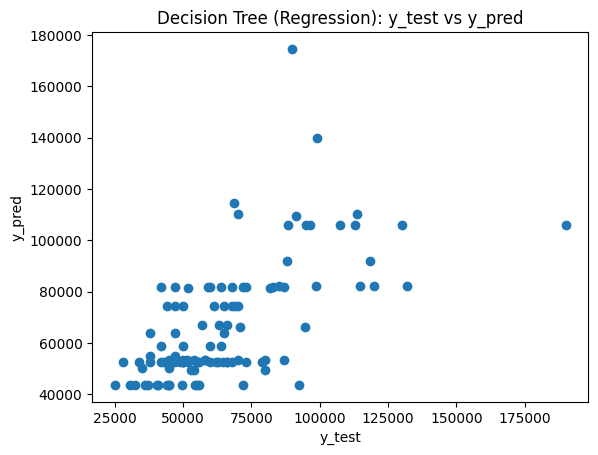

,feature,importance
1,lotsize,0.505502
3,bathrms,0.166623
0,rownames,0.100704
15,airco_yes,0.048413
10,fullbase_no,0.034312
14,airco_no,0.030496
2,bedrooms,0.024419
13,gashw_yes,0.023976
4,stories,0.021771
5,garagepl,0.019925


In [12]:
# y_test vs y_pred
plt.figure()
plt.scatter(y_test, y_pred)
plt.title("Decision Tree (Regression): y_test vs y_pred")
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

# Имена признаков после one-hot
oh = None
if categorical_features:
    oh = best_model.named_steps["prep"].transformers_[1][1].named_steps["onehot"]
num_names = numeric_features
cat_names = oh.get_feature_names_out(categorical_features).tolist() if oh is not None else []
feature_names = num_names + cat_names

# Важности
importances = best_model.named_steps["tree"].feature_importances_
imp_df = (pd.DataFrame({
    "feature": feature_names if len(feature_names)==len(importances) else [f"f{i}" for i in range(len(importances))],
    "importance": importances
})
.sort_values("importance", ascending=False)
.head(10))

imp_df


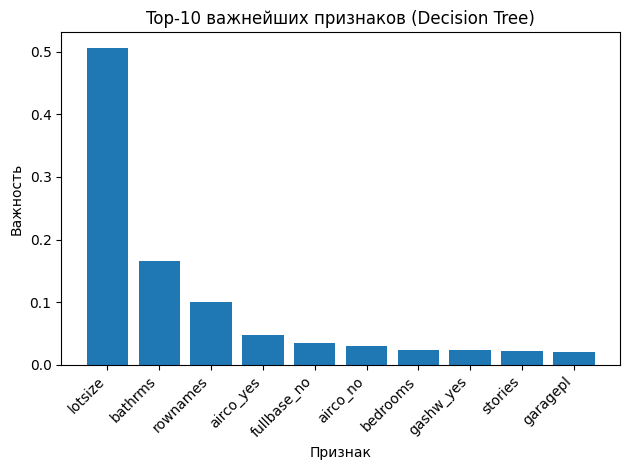

In [13]:
# Гистограмма топ-10
plt.figure()
plt.bar(imp_df["feature"], imp_df["importance"])
plt.title("Top-10 важнейших признаков (Decision Tree)")
plt.xlabel("Признак")
plt.ylabel("Важность")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Дерево решений: регрессия vs классификация

- **Классификация:** выбираем сплит по максимуму *прироста информации*, используя меру чистоты (энтропия Шеннона или Gini).
  
  Энтропия:
  $$
  H(p) = -\sum_k p_k \log_2 p_k
  $$
  Прирост информации:
  $$
  IG = H(parent) - \left[w_L H(left) + w_R H(right)\right]
  $$

- **Регрессия:** вместо энтропии минимизируем *ошибку* (обычно MSE/дисперсию).  
  Выбираем сплит, который сильнее всего уменьшает MSE на дочерних узлах.
